In [131]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

(np.float64(-0.5), np.float64(767.5), np.float64(429.5), np.float64(-0.5))

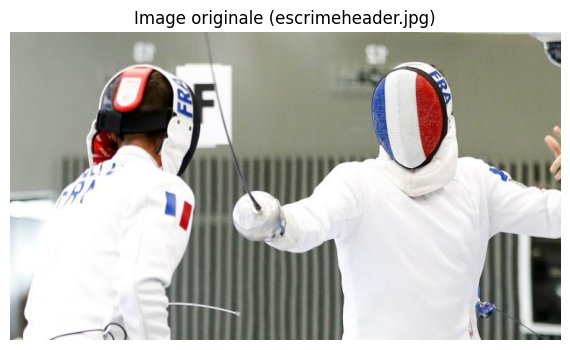

In [132]:
# Charger l'image: escrimeheader.jpg
import os

img_path = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), 'escrimeheader.jpg')

img = plt.imread(img_path)

# Normaliser en uint8 [0..255]
if img.dtype != np.uint8:
    img = np.clip(img * 255, 0, 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

# Si image en RGBA, garder RGB
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]

image = img

plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.title('Image originale (escrimeheader.jpg)')
plt.axis('off')

(np.float64(-0.5), np.float64(767.5), np.float64(429.5), np.float64(-0.5))

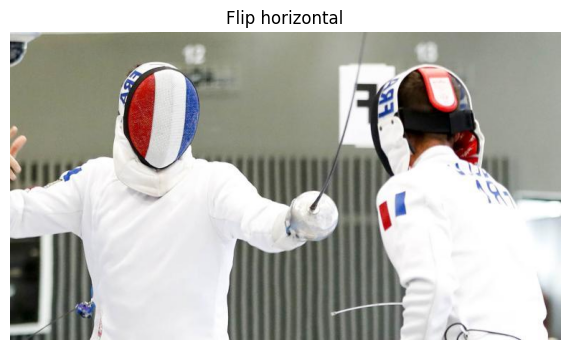

In [133]:
# 1. Flip horizontal (NumPy)
image_flipped = image[:, ::-1, :]

plt.figure(figsize=(12, 4))
plt.imshow(image_flipped)
plt.title('Flip horizontal')
plt.axis('off')

(np.float64(-0.5), np.float64(767.5), np.float64(429.5), np.float64(-0.5))

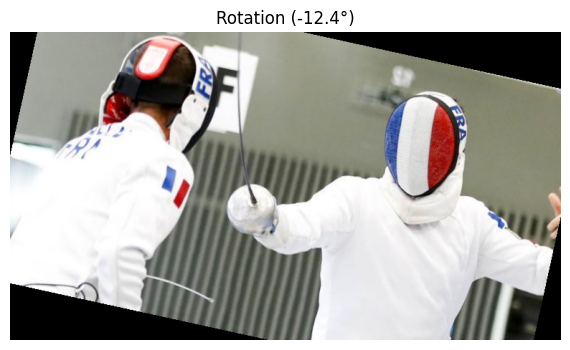

In [134]:
# 2. Rotation aléatoire plus importante (amplitude réglable)
def rotate_pil(img: np.ndarray, angle: float, expand: bool = False):
    """
    Rotation PIL simple.
    - img: numpy array (H, W, 3) en uint8 (0..255)
    - angle: degrés
    - expand=False: garde la même taille (ça peut couper un peu les coins)
    """
    img8 = img.astype(np.uint8, copy=False)
    return np.array(
        Image.fromarray(img8).rotate(angle, resample=Image.BILINEAR, expand=expand)
    )
    
angle = np.random.uniform(-15, 15)
image_rotated = rotate_pil(image, angle)

plt.figure(figsize=(12, 4))
plt.imshow(image_rotated)
plt.title(f'Rotation ({angle:.1f}°)')
plt.axis('off')

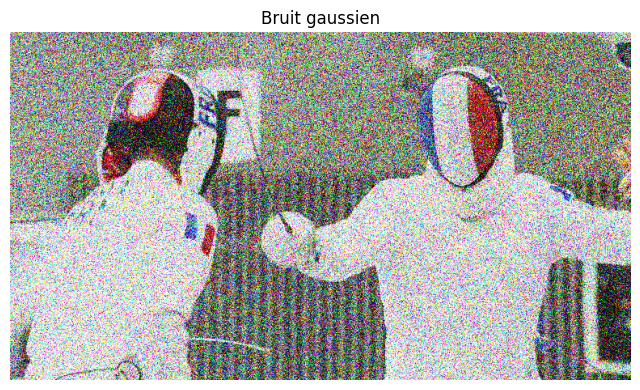

In [135]:
# 3. Ajout de bruit gaussien
mean = 0.0
std = 100.0

gaussian_noise = np.random.normal(mean, std, image.shape)
image_noisy = np.clip(image.astype(np.float32) + gaussian_noise, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.imshow(image_noisy)
plt.title('Bruit gaussien')
plt.axis('off')

plt.tight_layout()
plt.show()

## Fonction d'augmentation complète

Voici une fonction qui applique toutes les augmentations à la fois:

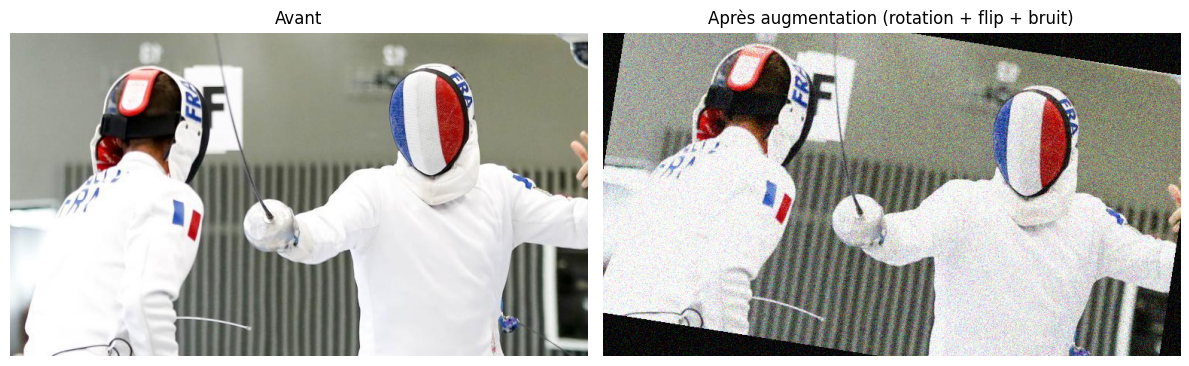

In [136]:
def _ensure_uint8_rgb(img: np.ndarray) -> np.ndarray:
    if not isinstance(img, np.ndarray):
        raise TypeError(f"Image attendue: numpy.ndarray, reçu: {type(img)}")

    if img.ndim == 2:
        # grayscale -> RGB
        img = np.stack([img, img, img], axis=-1)
    elif img.ndim == 3 and img.shape[2] == 4:
        # RGBA -> RGB
        img = img[:, :, :3]
    elif img.ndim != 3 or img.shape[2] != 3:
        raise ValueError(f"Image attendue: (H,W,3). Reçu shape={img.shape}.")

    if img.dtype != np.uint8:
        if np.nanmax(img) <= 1.0:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)

    return img


def augment_image_train(
    image: np.ndarray,
    *,
    p_flip: float = 0.5,
    noise_std_range=(15.0, 30.0),
) -> np.ndarray:
    """Augmentation train : rotation + flip horizontal + bruit gaussien."""

    # Vérif type/format au début
    image = _ensure_uint8_rgb(image)

    augmented = image.copy()

    # 1) Rotation aléatoire (PIL)
    angle = np.random.uniform(-15, 15)
    augmented = rotate_pil(image, angle)

    # 2) Flip horizontal
    if np.random.rand() < p_flip:
        augmented = augmented[:, ::-1, :]

    # 3) Bruit gaussien léger
    std = float(np.random.uniform(noise_std_range[0], noise_std_range[1]))
    noise = np.random.normal(0.0, std, augmented.shape)
    augmented = np.clip(augmented.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    return augmented


# --- Avant / Après (train) ---
augmented = augment_image_train(image)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Avant")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented)
plt.title("Après augmentation (rotation + flip + bruit)")
plt.axis("off")

plt.tight_layout()
plt.show()